---
layout: page
title: O Teorema Central do Limite
nav_order: 18
---
[<img src="https://raw.githubusercontent.com/flaviovdf/fcd/master/assets/colab_favicon_small.png" style="float: right;">](https://colab.research.google.com/github/flaviovdf/fcd/blob/master/_lessons/18-TCL.ipynb)

# T√≥pico 18 ‚Äì O Teorema Central do Limite
{: .no_toc .mb-2 }

Na sequ√™ncia do que aprendemos sobre a distribui√ß√£o Normal, vamos ver nessa aula um resultado impressionante que motiva o uso dessa distribui√ß√£o na grande maioria das aplica√ß√µes em Ci√™ncia de Dados: O Teorema Central do Limite. Em linhas gerais, esse resultado diz que, ainda que a distribui√ß√£o populacional na qual estamos interessados n√£o seja aproximadamente Normal, a distribui√ß√£o da m√©dia de uma amostra tomada dessa distribui√ß√£o vai ser, sob condi√ß√µes muito razo√°veis, aproximadamente Normal. Al√©m disso, o resultado corrobora nossa intui√ß√£o de que, quanto maior o tamanho da amostra sob a qual a m√©dia amostral √© calculada, mais precisa √© nossa estimativa e melhor √© a aproxima√ß√£o resultante.   
{: .fs-6 .fw-300 }

{: .no_toc .text-delta }
Resultados Esperados

1. Introduzir o Teorema Central do Limite (TCL).
1. Aprender a utilizar o TCL para fazer Infer√™ncia, em particular para calcular probabilidades e construir intervalos de confian√ßa.
1. Discutir a influ√™ncia do tamanho amostral em nossas estimativas, e comparar os pr√≥s e contras de se utilizar o bootstrap e o TCL nesse contexto. 

{: .no_toc .text-delta }
Material Adaptado do [DSC10 (UCSD)](https://dsc10.com/)

In [1]:
import numpy as np
import babypandas as bpd
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from scipy import stats

np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option("display.max_rows", 7)
pd.set_option("display.max_columns", 8)
pd.set_option("display.precision", 2)

# Animations
import time
from IPython.display import display, HTML, IFrame, clear_output
import ipywidgets as widgets

import warnings
warnings.filterwarnings('ignore')

def normal_curve(x, mu=0, sigma=1):
    return (1 / np.sqrt(2 * np.pi * sigma ** 2)) * np.exp((- (x - mu) ** 2) / (2 * sigma ** 2))

def normal_area(a, b, bars=False, title=None):
    x = np.linspace(-4, 4)
    y = normal_curve(x)
    ix = (x >= a) & (x <= b)
    plt.plot(x, y, color='black')
    plt.fill_between(x[ix], y[ix], color='gold')
    if bars:
        plt.axvline(a, color='red')
        plt.axvline(b, color='red')
    if title:
        plt.title(title)
    else:
        plt.title(f'Area between {np.round(a, 2)} and {np.round(b, 2)}')
    plt.show()
    
def area_within(z):
    title = f'Proportion of values within {z} SDs of the mean: {np.round(stats.norm.cdf(z) - stats.norm.cdf(-z), 4)}'
    normal_area(-z, z, title=title)   
    
def show_clt_slides():
    src = "https://docs.google.com/presentation/d/e/2PACX-1vTcJd3U1H1KoXqBFcWGKFUPjZbeW4oiNZZLCFY8jqvSDsl4L1rRTg7980nPs1TGCAecYKUZxH5MZIBh/embed?start=false&loop=false&delayms=3000&rm=minimal"
    width = 960
    height = 509
    display(IFrame(src, width, height))
    
def estimate_z():
    z = widgets.FloatSlider(value=2, min=0,max=4,step=0.05, description='z')
    ui = widgets.HBox([z])
    out = widgets.interactive_output(area_within, {'z': z})
    display(ui, out)
    
def plot_many_distributions(sample_sizes, sample_means):
    bins = np.arange(5, 30, 0.5)
    for size in sample_sizes:
        bpd.DataFrame().assign(data=sample_means[size]).plot(kind='hist', bins=bins, density=True, ec='w', title=f'Distribution of the Sample Mean for Samples of Size {size}', figsize=(8, 4))
        plt.legend('');
        plt.show()
        time.sleep(1.5)
        if size != sample_sizes[-1]:
            clear_output()

## Recapitulando: Padroniza√ß√£o

### Unidades padronizadas

Lembre que, se $X$ √© uma vari√°vel aleat√≥ria (num√©rica) com m√©dia $\mu$ e vari√¢ncia $\sigma^2$, e se $X_i$ √© um valor (realiza√ß√£o) dessa vari√°vel, ent√£o

$$\begin{align*}
    Z_i := \frac{X_i - \mu}{\sigma}
\end{align*}$$

representa $X_i$ em **unidades padronizadas**, isto √©, o n√∫mero de DPs $\sigma$ que $X_i$ est√° de sua m√©dia $\mu$ .

Na vers√£o amostral, isto √©, ap√≥s coletar uma amostra $\mathbf{X} := (X_1, \ldots, X_n)$ com m√©dia $\bar{X}$ e vari√¢ncia $S^2$, as observa√ß√µes padronizadas s√£o definidas por

\begin{align*}
    Z_i := \frac{X_i - \bar{X}}{S},
\end{align*}

com a mesma interpreta√ß√£o acima, mas relativa √† distribui√ß√£o da amostra.

### Exemplo r√°pido: pontua√ß√£o no SAT

As notas no SAT v√£o de 0 a 1,600. A distribui√ß√£o das notas do SAT tem uma m√©dia de 950 e um desvio padr√£o de 300. 

Se um amigo te diz que ele tirou 2.5 no SAT (em unidades padronizadas), o que voc√™ conclui?

## O Teorema Central do Limite

### Atrasos de v√¥os (mais uma vez) ‚úàÔ∏è

A distribui√ß√£o dos atrasos de v√¥os que analisamos anteriormente _n√£o √©_ aproximadamente Normal.

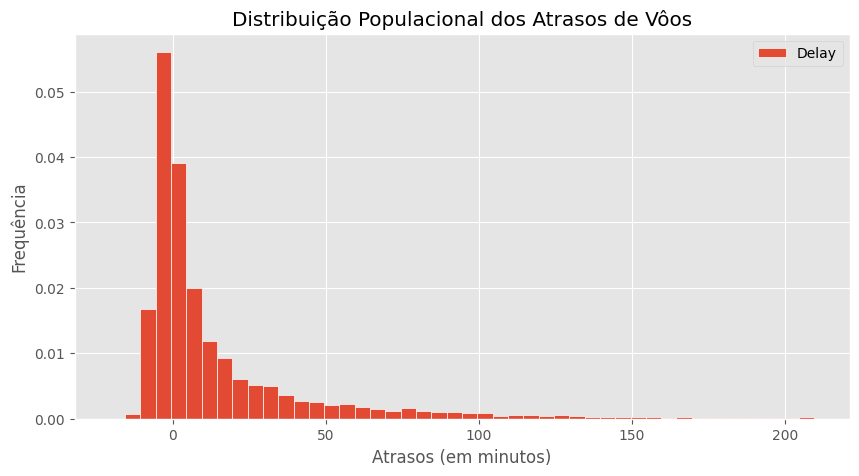

In [2]:
delays = bpd.read_csv('https://raw.githubusercontent.com/flaviovdf/fcd/master/assets/17-Normalidade/data/united_summer2015.csv')
delays.plot(kind='hist', y='Delay', bins=np.arange(-20.5, 210, 5), density=True, ec='w', figsize=(10, 5), title='Distribui√ß√£o Populacional dos Atrasos de V√¥os')
plt.xlabel('Atrasos (em minutos)')
plt.ylabel("Frequ√™ncia");

In [3]:
delays.get('Delay').describe()

count    13825.00
mean        16.66
std         39.48
           ...   
50%          2.00
75%         18.00
max        580.00
Name: Delay, Length: 8, dtype: float64

### Distribui√ß√£o emp√≠rica de uma estat√≠stica

- Antes de apresentarmos as medidas de centralidade, dispers√£o e a distribui√ß√£o Normal, discutimos o bootstrap.

- Mais especificamente, utilizamos o boostrap para construir uma aproxima√ß√£o para a **distribui√ß√£o de uma estat√≠stica (por exemplo a m√©dia ou a mediana amostrais)**, com base em **uma √∫nica amostra**.

- A partir dessa distribui√ß√£o (a distribui√ß√£o bootstrap da estat√≠stica), constru√≠mos intervalos de confian√ßa para o par√¢metro populacional de interesse.

- No contexto dessa aula, suponha que nosso par√¢metro de interesse seja a m√©dia populacional.
    - Estaremos ent√£o interessados em aproximar a **distribui√ß√£o da m√©dia amostral**.

- Nessa aula, introduziremos uma t√©cnica para aproximar a distribui√ß√£o da m√©dia amostral **sem recorrermos ao bootstrap**.
    - Faremos isso com a utiliza√ß√£o do ferramental de Infer√™ncia Estat√≠stica, desenvolvida com s√≥lidos fundamentos matem√°ticos baseados na Teoria de Probabilidade.
    - Lembre da nossa discuss√£o em sala de aula: a teoria Estat√≠stica e o ferramental matem√°tico em geral devem **fundamentar, integrar e complementar** o que conseguimos aprender a calcular com base em m√©todos de simula√ß√£o!

### Distribui√ß√£o emp√≠rica da m√©dia amostral 

Como nesse caso espec√≠fico temos acesso √† popula√ß√£o dos atrasos de v√¥os, inicialmente vamos aproximar a distribui√ß√£o amostral da m√©dia com base na m√©dia amostral de diferentes amostras, tiradas (com reposi√ß√£o) da popula√ß√£o original.

- Importante: isso **n√£o √© boostrapping!**
- Essa abordagem tamb√©m **n√£o √© muito pr√°tica**.
    - Se tiv√©ssemos acesso √† popula√ß√£o completa, n√£o precisar√≠amos realizar nenhum tipo de infer√™ncia ‚Äì bastaria simplesmente calcular a m√©dia populacional diretamente.

In [4]:
sample_means = np.array([])
repetitions = 2000

for i in np.arange(repetitions):
    sample = delays.sample(500) # Not bootstrapping!
    sample_mean = sample.get('Delay').mean()
    sample_means = np.append(sample_means, sample_mean)
    
sample_means

array([18.49, 20.18, 18.95, ..., 15.67, 15.12, 17.32])

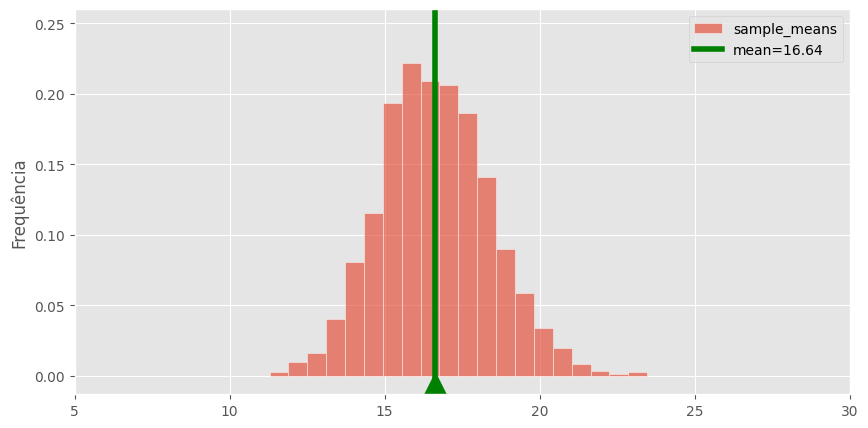

In [5]:
bpd.DataFrame().assign(sample_means=sample_means).plot(kind='hist', density=True, ec='w', alpha=0.65, bins=20, figsize=(10, 5));
plt.scatter([sample_means.mean()], [-0.005], marker='^', color='green', s=250)
plt.axvline(sample_means.mean(), color='green', label=f'mean={np.round(sample_means.mean(), 2)}', linewidth=4)
plt.xlim(5, 30)
plt.ylim(-0.013, 0.26)
plt.legend()
plt.ylabel("Frequ√™ncia");

Note que _essa distribui√ß√£o_ √© aproximadamente Normal, ainda que a _distribui√ß√£o da popula√ß√£o_ n√£o seja.

Note ainda que a distribui√ß√£o emp√≠rica das m√©dias constru√≠da dessa maneira _est√° centrada na m√©dia populacional_.

### O Teorema Central do Limite

> O Teorema Central do Limite (TCL) nos diz que a distribui√ß√£o de probabilidade da **m√©dia** de uma amostra de tamanho "grande o suficiente" ser√° "sempre" aproximadamente Normal, qualquer que seja a popula√ß√£o da qual a amostra foi retirada.

Embora as f√≥rmulas a seguir dizem respeito ao comportamento de _m√©dias_, os resultados do teorema s√£o v√°lidos tamb√©m para diferentes tipos de _somas_.

### Caracter√≠sticas da distribui√ß√£o da m√©dia amostral

- **Forma**: O TCL nos diz que a distribui√ß√£o da m√©dia amostral ser√° sempre aproximadamente Normal.

- **Loca√ß√£o**: A distribui√ß√£o da m√©dia amostral vai estar **centrada** na m√©dia populacional.

- **Escala**: Discutiremos um pouco abaixo sobre a vari√¢ncia/desvio padr√£o da distribui√ß√£o da m√©dia amostral.
    - Mas antes, para refletir, pense na seguinte pergunta: "Como a **dispers√£o** dessa distribui√ß√£o seria afetada pelo tamanho amostral?"

### Influ√™ncia do tamanho amostral

A fun√ß√£o `sample_mean_delays` definida abaixo toma um argumento do tipo integer (`sample_size`), e ent√£o:
1. Toma uma amostra de tamanho $n = $ `sample_size` da popula√ß√£o de atrasos de v√¥os.
2. Calcula a m√©dia amostral correspondente.
3. Rep√µe a amostra e itera os passos 1 a 2 acima um n√∫mero $M = 2.000$ de vezes, retornando uma array com as m√©dias amostrais de cada itera√ß√£o.

In [6]:
def sample_mean_delays(sample_size):
    sample_means = np.array([])
    for i in np.arange(2000):
        sample = delays.sample(sample_size)
        sample_mean = sample.get('Delay').mean()
        sample_means = np.append(sample_means, sample_mean)
    return sample_means

In [7]:
sample_size = 100
sample_mean_delays(sample_size)

array([14.37, 22.12, 22.52, ..., 19.02, 19.3 , 23.2 ])

Vamos agora invocar `sample_mean_delays` em um array contendo diferentes valores de `sample_size`.

In [8]:
sample_means = {}
sample_sizes = [5, 10, 50, 100, 200, 400, 800, 1600]

for size in sample_sizes:
    sample_means[size] = sample_mean_delays(size)

sample_means

{5: array([-3.6,  9.8, 30.6, ...,  5.8,  6.6,  5.6]),
 10: array([32.4, 30.4,  9.3, ..., 17.3, 30.4, 22.6]),
 50: array([14.02, 12.82, 16.52, ..., 16.32, 10.86, 25.46]),
 100: array([11.87, 16.48, 18.2 , ...,  9.64, 16.96,  5.42]),
 200: array([19.96, 20.27, 17.89, ..., 25.09, 12.71, 11.74]),
 400: array([15.46, 20.77, 15.55, ..., 14.68, 16.7 , 18.32]),
 800: array([19.48, 18.38, 17.65, ..., 14.21, 17.94, 14.4 ]),
 1600: array([15.87, 16.95, 15.94, ..., 15.57, 16.39, 16.28])}

Vamos agora analisar as distribui√ß√µes (emp√≠ricas) das m√©dias amostrais resultantes desse processo.

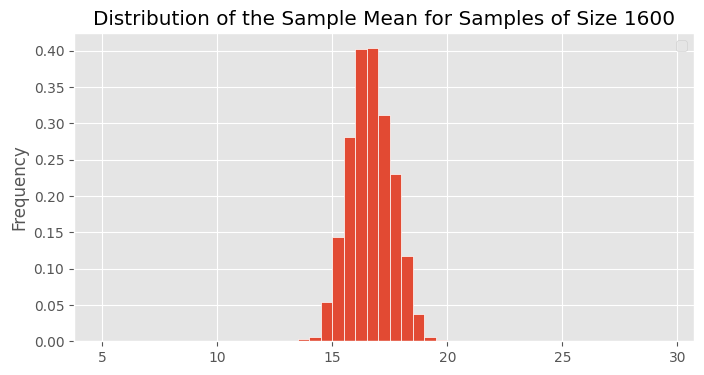

In [9]:
plot_many_distributions(sample_sizes, sample_means)

O que voc√™ consegue notar no processo acima? ü§î

### Vari√¢ncia da distribui√ß√£o da m√©dia amostral

- √Ä medida que o nosso tamanho amostral $n$ aumenta, a distribui√ß√£o da m√©dia se torna cada vez "mais Normal", e sua vari√¢ncia diminui.
    - Visualmente, utilizando o que sabemos sobre a distribui√ß√£o Normal, voc√™ consegue determinar aproximadamente o _quanto_ a vari√¢ncia diminui com o tamanho amostral?

In [10]:
# Compute the standard deviation of each distribution.
vars = np.array([])
for size in sample_sizes:
    var = np.var(sample_means[size])
    vars = np.append(vars, var)
vars

array([314.54, 151.66,  32.  ,  15.72,   7.88,   3.7 ,   1.82,   0.86])

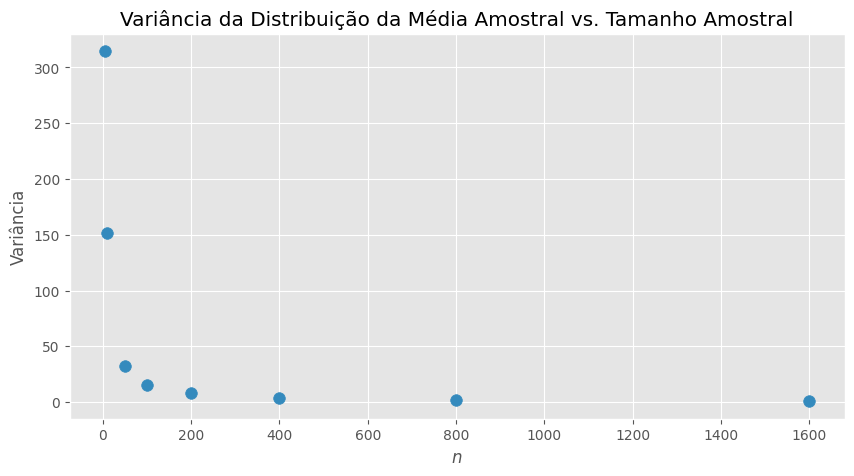

In [11]:
observed = bpd.DataFrame().assign(
    SampleSize=sample_sizes,
    Variance=vars
)

observed.plot(kind='scatter', x='SampleSize', y='Variance', s=70, title="Vari√¢ncia da Distribui√ß√£o da M√©dia Amostral vs. Tamanho Amostral", figsize=(10, 5))
plt.xlabel("$n$")
plt.ylabel("Vari√¢ncia");

Aparentemente, √† medida que $n$ aumenta, a vari√¢ncia da distribui√ß√£o da m√©dia amostral diminui _drasticamente_.

### Vari√¢ncia da distribui√ß√£o da m√©dia amostral

- √Ä medida que aumentamos o tamanho amostral, a distribui√ß√£o da m√©dia amostral fica cada vez mais "estreita", isto √©, menos dispersa.
    - Em outras palavras, a distribui√ß√£o da m√©dia amostral fica cada vez mais **concentrada** em torno da m√©dia populacional. 

- Mais precisamente, a lei que rege a vari√¢ncia das m√©dias amostrais √© do tipo

\begin{align*}
    \text{var}(\bar{X}) = \frac{\sigma^2}{n},
\end{align*}

em que $\sigma^2$ √© a vari√¢ncia populacional.

- Em outras palavras, √† medida que o tamanho amostral $n$ cresce, a vari√¢ncia das m√©dias amostrais diminui de maneira _diretamente proporcional_ (i.e. _linear_).
    - Analogamente, o desvio padr√£o diminui com a raiz quadrada de $n$, pois aqui $\sqrt{\text{var}(\bar{X})} = \sigma/\sqrt{n}$.

Essas defini√ß√µes e resultados ser√£o explicadas de maneira mais precisa em um pr√≥ximo curso de Probabilidade. 

No contexto desse curso, por√©m, temos uma conclus√£o importante: quando coletamos amostras de tamanho maior, a m√©dia amostral se aproxima cada vez mais da m√©dia populacional.

> Isto √©, √† medida que o tamanho amostral aumenta, nossa estimativa para a m√©dia populacional se torna cada vez melhor!

- **Importante**: A afirma√ß√£o acima **n√£o** √© sobre a vari√¢ncia ou desvio padr√£o _amostrais_ $S^2$ e $S$, mas sim sobre a vari√¢ncia/DP populacional, que √© relativa √† distribui√ß√£o de _todas as poss√≠veis m√©dias amostrais_.
- Dessa forma, ao aumentar o tamanho amostral $n$:
    - **N√£o √© verdade** ‚ùå que nosso DP amostral $S$ vai diminuir;
    - **√â verdade** ‚úÖ que o DP da distribui√ß√£o amostral da m√©dia amostral (e que √© igual ao DP populacional $\sigma$ dividido por $\sqrt{n}$) vai diminuir.

### Recapitulando: Distribui√ß√£o da m√©dia amostral

- **Forma**: O TCL nos diz que a distribui√ß√£o da m√©dia amostral ser√° sempre aproximadamente Normal.

- **Loca√ß√£o**: A distribui√ß√£o da m√©dia amostral vai estar **centrada** na m√©dia populacional.

- **Escala**: A vari√¢ncia da distribui√ß√£o da m√©dia amostral diminui linearmente com $n$ (e o desvio padr√£o correspondente diminui com $\sqrt{n}$). 

**üö® Problema**: Tanto a m√©dia quanto o desvio padr√£o da m√©dia amostral dependem de par√¢metros da populac√£o original ($\mu$ e $\sigma^2$), mas na pr√°tica **n√£o temos acesso √† essa informa√ß√£o!**

### Boostrap vs. TCL

- Lembre que no bootstrap nosso objetivo era aproximar a distribui√ß√£o de uma estat√≠stica (por exemplo, a m√©dia amostral), utilizando **simula√ß√£o** e nos baseando em uma √∫nica amostra.

- O TCL descreve o comportamento a distribui√ß√£o da m√©dia amostral atrav√©s de uma **lei matem√°tica**/Estat√≠stica, mas depende de informa√ß√£o da popula√ß√£o ($\mu$ e $\sigma$).

- **Ideia importante**: A m√©dia $\bar{X}$ e o DP $S$ amostrais s√£o usualmente boas aproxima√ß√µes para $\mu$ e $\sigma$, respectivamente. Dessa forma, podemos utiliz√°-los como aproxima√ß√µes no pr√≥prio TCL!

- Dessa forma, com base no TCL podemos **aproximar a distribui√ß√£o da m√©dia amostral, com base em uma √∫nica amostra, mas sem bootstrap nem simula√ß√£o!**

### Aproximando a distribui√ß√£o da m√©dia amostral via bootstrap

Vamos come√ßar tomando uma amostra de tamanho $n = 500$ do `DataFrame` `delays`.

In [12]:
np.random.seed(42)
my_sample = delays.sample(500)
my_sample.get('Delay').describe()

count    500.00
mean      13.01
std       28.00
          ...  
50%        3.00
75%       16.00
max      209.00
Name: Delay, Length: 8, dtype: float64

Para aproximar a distribui√ß√£o da m√©dia amostral, podemos realizar ent√£o um bootstrap (aqui $B = 2,000$):

In [13]:
resample_means = np.array([])
repetitions = 2000

for i in np.arange(repetitions):
    resample = my_sample.sample(500, replace=True) # Bootstrapping!
    resample_mean = resample.get('Delay').mean()
    resample_means = np.append(resample_means, resample_mean)
    
resample_means

array([12.65, 11.5 , 11.34, ..., 12.59, 11.89, 12.58])

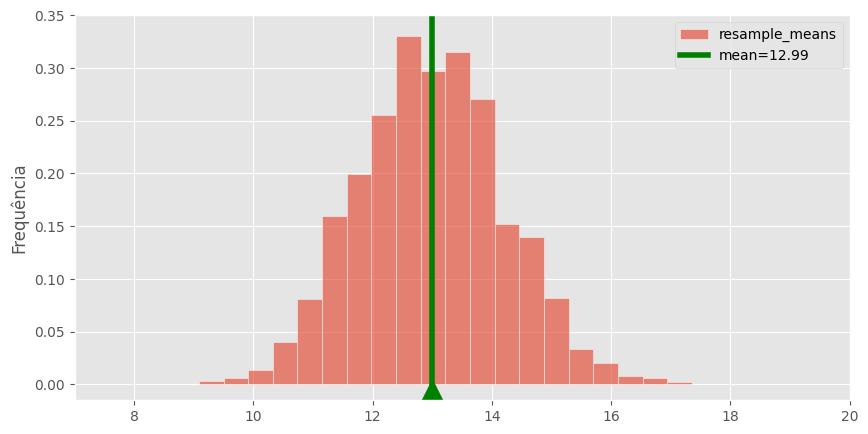

In [14]:
bpd.DataFrame().assign(resample_means=resample_means).plot(kind='hist', density=True, ec='w', alpha=0.65, bins=20, figsize=(10, 5));
plt.scatter([resample_means.mean()], [-0.005], marker='^', color='green', s=250)
plt.axvline(resample_means.mean(), color='green', label=f'mean={np.round(resample_means.mean(), 2)}', linewidth=4)
plt.xlim(7, 20)
plt.ylim(-0.015, 0.35)
plt.legend()
plt.ylabel("Frequ√™ncia");

### Aproximando a distribui√ß√£o da m√©dia amostral com o TCL

Utilizando a m√©dia amostral $\bar{X}$ e a vari√¢ncia amostral $S^2$ como estimativas da m√©dia populacional $\mu$ e da vari√¢ncia populacional $\sigma^2$, o TCL nos diz que a distribui√ß√£o da m√©dia amostral ser√° aproximadamente Normal, centrada na pr√≥pria m√©dia amostral $\bar{X}$ e com vari√¢ncia igual a $S^2/n$.

A m√©dia amostral de `my_sample` √© igual a:

In [15]:
sample_mean_mean = my_sample.get('Delay').mean()
sample_mean_mean

13.008

e o desvio padr√£o correspondente √©:

In [16]:
sample_mean_sd = np.std(my_sample.get('Delay')) / np.sqrt(my_sample.shape[0])
sample_mean_sd

1.2511114546674091

Vamos ent√£o elaborar o gr√°fico de uma curva Normal com m√©dia $\bar{X}$ e DP $S/\sqrt{n}$ e sobrepor √† distribui√ß√£o bootstrap obtida acima.

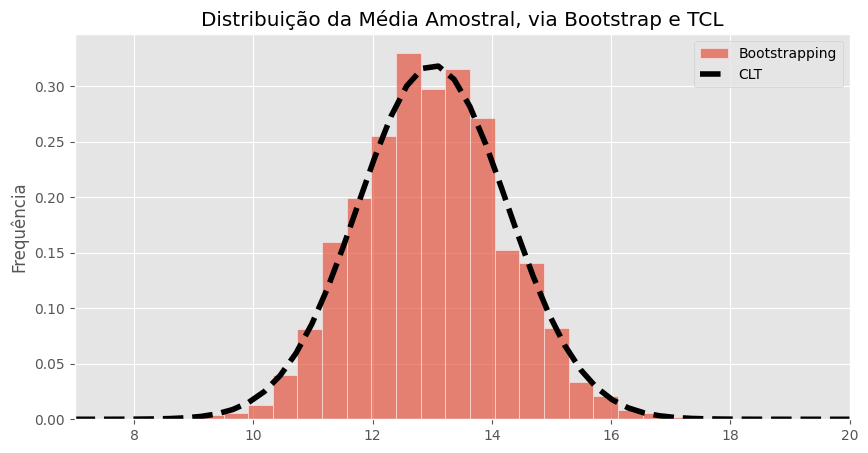

In [17]:
norm_x = np.linspace(7, 20)
norm_y = normal_curve(norm_x, mu=sample_mean_mean, sigma=sample_mean_sd)
bpd.DataFrame().assign(Bootstrapping=resample_means).plot(kind='hist', density=True, ec='w', alpha=0.65, bins=20, figsize=(10, 5));
plt.plot(norm_x, norm_y, color='black', linestyle='--', linewidth=4, label='CLT')
plt.title('Distribui√ß√£o da M√©dia Amostral, via Bootstrap e TCL')
plt.xlim(7, 20)
plt.legend()
plt.ylabel("Frequ√™ncia");

A aproxima√ß√£o √© muito boa, e **sem fazer nenhuma simula√ß√£o!**

In [18]:
show_clt_slides()

## Intervalos de confian√ßa utilizando o TCL

Da mesma forma que fizemos atrav√©s do bootstrap, podemos construir intervalos de confian√ßa tamb√©m com o TCL.

- Lembre que, no bootstrap, os intervalos de $\gamma\%$ de confian√ßa s√£o em geral calculados como os percentis $(1 - \gamma)/2$ e $(1 + \gamma)/2$ da _distribui√ß√£o bootstrap_.

- Utilizando o TCL, basta pegarmos os mesmos percentis, _por√©m da distribui√ß√£o Normal_ com m√©dia $\bar{X}$ e vari√¢ncia $\sigma^2/n$.

#### Intervalo de 95% de confian√ßa via bootstrap

Com base nos resultados do bootstrap acima ($B = 2,000$), os percentis 2.5% e 97.5% da distribui√ß√£o bootstrap s√£o:

In [19]:
left_boot = np.percentile(resample_means, 2.5)
right_boot = np.percentile(resample_means, 97.5)
[left_boot, right_boot]

[10.7159, 15.43405]

Visualmente:

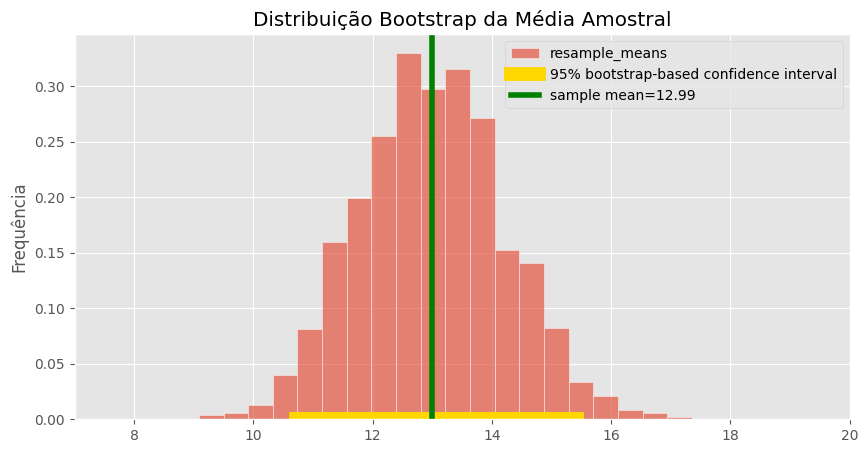

In [20]:
bpd.DataFrame().assign(resample_means=resample_means).plot(kind='hist', y='resample_means', alpha=0.65, bins=20, density=True, ec='w', figsize=(10, 5), title='Distribui√ß√£o Bootstrap da M√©dia Amostral');
plt.plot([left_boot, right_boot], [0, 0], color='gold', linewidth=10, label='95% bootstrap-based confidence interval');
plt.axvline(resample_means.mean(), color='green', label=f'sample mean={np.round(resample_means.mean(), 2)}', linewidth=4)
plt.xlim(7, 20);
plt.legend()
plt.ylabel("Frequ√™ncia");

#### Intervalo de 95% de confian√ßa via TCL

Com o TCL, basta tomarmos os percentis 2.5% e 97.5% da distribui√ß√£o Normal com m√©dia $\bar{X}$ e vari√¢ncia $S^2/n$.

A m√©dia amostral aqui √© igual a

In [21]:
sample_mean_mean = my_sample.get('Delay').mean()
sample_mean_mean

13.008

E o desvio padr√£o amostral (dividido pela raiz do tamanho amostral) √© igual a

In [22]:
sample_mean_sd = np.std(my_sample.get('Delay')) / np.sqrt(my_sample.shape[0])
sample_mean_sd

1.2511114546674091

Dessa forma, a distribui√ß√£o da m√©dia amostral √©, aproximadamente:

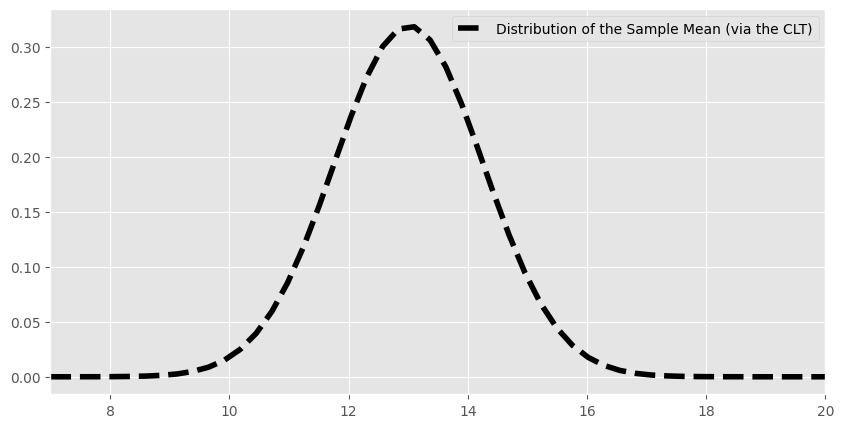

In [23]:
plt.figure(figsize=(10, 5))
norm_x = np.linspace(7, 20)
norm_y = normal_curve(norm_x, mu=sample_mean_mean, sigma=sample_mean_sd)
plt.plot(norm_x, norm_y, color='black', linestyle='--', linewidth=4, label='Distribution of the Sample Mean (via the CLT)')
plt.xlim(7, 20)
plt.legend();

- Para encontrarmos os percentis 2.5% e 97.5% dessa distribui√ß√£o, lembre da √∫ltima aula que, _na distribui√ß√£o Normal, aproximadamente 95% dos valores est√£o a 2 DPs da m√©dia_.
    - Isso vale para _qualquer distribui√ß√£o Normal_!

- Utilizando esse fato, como a m√©dia da distribui√ß√£o acima √© igual a $\bar{X}$ e seu desvio padr√£o √© igual a $S/\sqrt{n}$, temos que o percentil 2.5% (limite inferior do IC95%) √© igual a $\bar{X} - 2 \cdot S/\sqrt{n}$, e o percentil 95% (limite superior do IC95%) √© igual a $\bar{X} + 2 \cdot S/\sqrt{n}$. 

In [24]:
left_normal = sample_mean_mean - 2 * sample_mean_sd
right_normal = sample_mean_mean + 2 * sample_mean_sd
[left_normal, right_normal]

[10.50577709066518, 15.510222909334818]

Visualmente:

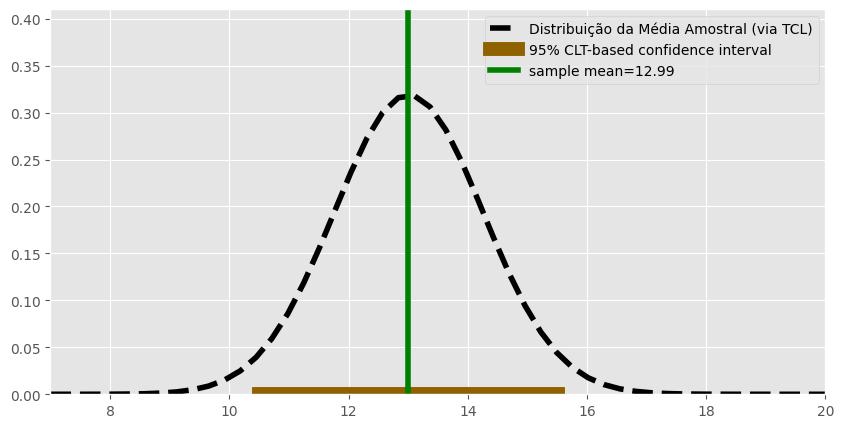

In [25]:
plt.figure(figsize=(10, 5))
norm_x = np.linspace(7, 20)
norm_y = normal_curve(norm_x, mu=sample_mean_mean, sigma=sample_mean_sd)
plt.plot(norm_x, norm_y, color='black', linestyle='--', linewidth=4, label='Distribui√ß√£o da M√©dia Amostral (via TCL)')
plt.xlim(7, 20)
plt.ylim(0, 0.41)
plt.plot([left_normal, right_normal], [0, 0], color='#8f6100', linewidth=10, label='95% CLT-based confidence interval')
plt.axvline(resample_means.mean(), color='green', label=f'sample mean={np.round(resample_means.mean(), 2)}', linewidth=4)
plt.legend();

#### Comparando os intervalos

Vamos agora comparar os ICs obtidos por ambas as t√©cnicas!

O IC via bootstrap √© dado por

In [26]:
[left_boot, right_boot]

[10.7159, 15.43405]

e o IC calculado atrav√©s do TCL √© dado por

In [27]:
[left_normal, right_normal]

[10.50577709066518, 15.510222909334818]

Os resultados s√£o bem pr√≥ximos!

### Resumo: IC para a m√©dia populacional via TCL

Com base no TCL, o IC95% para a m√©dia populacional √© dado por

\begin{equation*}
    IC_{95\%}(\mu) = \bar{X} \pm 2 \cdot \frac{S}{\sqrt{n}} = \left[\bar{X} - 2 \cdot \frac{S}{\sqrt{n}}; \,\,\,\, \bar{X} + 2 \cdot \frac{S}{\sqrt{n}}\right].
\end{equation*}

Analogamente, para um n√≠vel $\gamma\%$ qualquer de confian√ßa (i.e. para $0 < \gamma < 1$), temos

\begin{equation*}
    IC_{\gamma\%}(\mu) := \bar{X} \pm Z_{(1 + \gamma)/2} \cdot \frac{S}{\sqrt{n}} = \left[\bar{X} - Z_{(1 + \gamma)/2} \cdot \frac{S}{\sqrt{n}}; \,\,\,\, \bar{X} + Z_{(1 + \gamma)/2} \cdot \frac{S}{\sqrt{n}}\right],
\end{equation*}

onde $Z_{(1 + \gamma)/2}$ denota o percentil $(1 + \gamma)/2$ da distribui√ß√£o _Normal padr√£o_.

### Observa√ß√µes acerca dos percentis da distribui√ß√£o Normal

Se quisermos ser mais precisos, o quantil 2.5% e 97.5% da distribui√ß√£o Normal padr√£o s√£o, na verdade, _aproximadamente $\pm 1.96$_. 

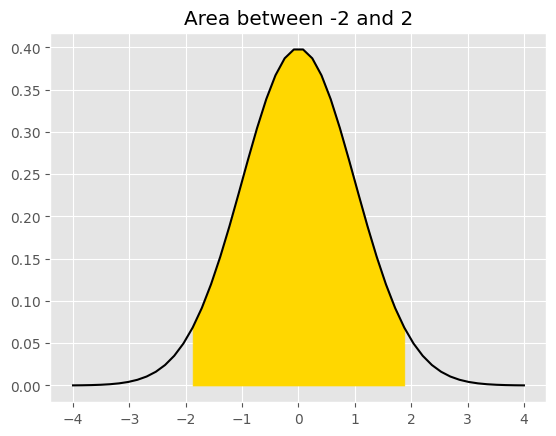

In [28]:
normal_area(-2, 2)

In [29]:
stats.norm.cdf(2) - stats.norm.cdf(-2)

0.9544997361036416

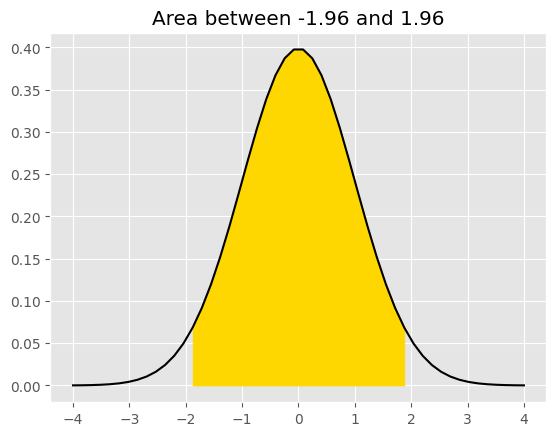

In [30]:
normal_area(-1.96, 1.96)

In [31]:
stats.norm.cdf(1.96) - stats.norm.cdf(-1.96)

0.950004209703559

Por√©m, na maioria dos casos, tomar $\pm 2$ leva √† uma aproxima√ß√£o bem razo√°vel, com uma diferen√ßa de apenas $0.45\%$ na probabilidade entre $\pm 1.96$ e $\pm 2$.

Por √∫ltimo, note que o intervalo definido na f√≥rmula acima √© na verdade dado por

\begin{equation*}
    \left[\bar{X} + Z_{(1 - \gamma)/2} \cdot \frac{S}{\sqrt{n}}; \,\,\,\, \bar{X} + Z_{(1 + \gamma)/2} \cdot \frac{S}{\sqrt{n}}\right].
\end{equation*}

Por√©m, utilizando a propriedade de reflexividade da distribui√ß√£o Normal, sabemos que $Z_{(1 + \gamma)/2} > 0$ e que $Z_{(1 - \gamma)/2} = - Z_{(1 + \gamma)/2}$, de onde obtemos a forma definida anteriormente.

### E como encontramos esses percentis?

Suponha agora que, ao inv√©s de $\gamma = 95\%$, queiramos construir um IC de $\gamma = 90\%$ de confian√ßa.

Como podemos encontrar $Z_{(1 + \gamma)/2}$ nesse caso?

- Alternativa 1: utilizar uma tabela com a CDF da distribui√ß√£o Normal padr√£o.
- Alternativa 2: utilizar a fun√ß√£o `stats.norm.ppf`!

A fun√ß√£o `stats.norm.ppf` toma um argumento `p` (uma probabilidade, e logo entre 0 e 1) e retorna o percentil equivalente ao valor de `p`.

In [32]:
stats.norm.ppf(0.9773)

2.000929388101571

In [33]:
stats.norm.ppf(1 - 0.9773)

-2.000929388101571

In [34]:
stats.norm.ppf(0.975)

1.959963984540054

In [35]:
stats.norm.ppf(1 - 0.975)

-1.959963984540054

In [36]:
round(stats.norm.ppf(0.975), 2)

1.96

In [37]:
estimate_z()

Output()

Dessa forma, se quisermos construir um IC90% para a m√©dia populacional, primeiramente calculamos os percentis 5% e 95%:

In [38]:
stats.norm.ppf(0.05)

-1.6448536269514729

In [39]:
stats.norm.ppf(0.95)

1.6448536269514722

Depois, basta substituir na f√≥rmula que t√≠nhamos anteriormente:

In [40]:
left_normal = sample_mean_mean - 1.64 * sample_mean_sd
right_normal = sample_mean_mean + 1.64 * sample_mean_sd
[left_normal, right_normal]

[10.956177214345448, 15.05982278565455]

In [41]:
## for more precision (and efficiency), we can simply call
left_normal = sample_mean_mean - stats.norm.ppf(0.95) * sample_mean_sd
right_normal = sample_mean_mean + stats.norm.ppf(0.95) * sample_mean_sd
[left_normal, right_normal]

[10.95010478606978, 15.065895213930219]

### Resumo: Bootstrap vs. TCL

| | Bootstrap | TCL |
| --- | --- | --- |
| **Pr√≥s** | Funciona para v√°rias estat√≠sticas diferentes <br> (m√©dia, mediana, desvio padr√£o). | Precisa de apenas 3 quantidades ‚Äì <br>m√©dia amostral, DP amostral e tamanho amostral. |
| **Contras** | Computacionalmente intensivo (requer a simula√ß√£o de muitas <br> e muitas amostras da amostra original). | Funciona apenas para a m√©dia/soma amostral. |

### Teste r√°pido ‚úÖ 

Qual desses histogramas corresponde √† distribui√ß√£o da m√©dia amostral para amostras de tamanho $n = 100$ tiradas de uma popula√ß√£o com m√©dia $\mu = 50$ e DP $\sigma = 20$??

<center><img src='https://raw.githubusercontent.com/flaviovdf/fcd/master/assets/18-TCL/images/which-histogram.png' width=900></center>

## Resumo e pr√≥xima aula

### Resumo

- O Teorema Central do Limite nos diz que a distribui√ß√£o de probabilidade da **m√©dia amostral** de uma amostra com tamanho suficientemente grande ser√° aproximadamente Normal, qualquer que seja a popula√ß√£o original da qual a amostra √© coletada.
    - Esse resultado tamb√©m vale para diversos tipos de _somas_.
- O TCL tamb√©m nos diz que:
    - A distribui√ß√£o da m√©dia amostral ser√° centrada na m√©dia populacional;
    - O DP da distribui√ß√£o da m√©dia amostral √© igual a $\sigma/\sqrt{n}$.
- Com base no TCL, podemos construir um IC de $\gamma\%$ de confian√ßa para a m√©dia populacional $\mu$ da seguinte forma:

\begin{equation*}
    IC_{\gamma\%}(\mu) := \bar{X} \pm Z_{(1 + \gamma)/2} \cdot \frac{S}{\sqrt{n}} = \left[\bar{X} - Z_{(1 + \gamma)/2} \cdot \frac{S}{\sqrt{n}}; \,\,\,\, \bar{X} + Z_{(1 + \gamma)/2} \cdot \frac{S}{\sqrt{n}}\right],
\end{equation*}

em que $Z_{(1 + \gamma)/2}$ denota o percentil $(1 + \gamma)/2$ da distribui√ß√£o _Normal padr√£o_.

### Pr√≥xima aula

- Discutiremos como escolher tamanhos de amostra com base na precis√£o desejada para nossas estat√≠sticas0.
    - Por exemplo, se quisermos construir um IC com amplitude de _no m√°ximo $w$_, qual o tamanho de amostra necess√°rio para isso?
- Introduziremos no√ß√µes b√°sicas de como _testar hip√≥teses_ acerca da popula√ß√£o da qual amostramos.